# 作業1 : 辨識名畫的作者

資料集: [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)

程式碼參考自: [Tensorflow](https://www.tensorflow.org/)

> **資料集說明**

After being challenged many times by my girlfriend about who is the best to guess the painter, I decided to use the power of machine learning to defeat her.I gathered a collection of artworks of the 50 most influential artists of all time.

請幫幫資料集作者完成他女朋友的挑戰。**訓練一個CNN模型輸入是一張畫作，辨識出這張畫可能是哪個畫家的作品。**

<!-- 
>**作業說明**

**第一步驟**: 左上角 檔案->在雲端硬碟建立副本。

**第二步驟**: 右上角 共用->取得連結->任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段->更變執行類型->GPU。 可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個colab的程式來完成訓練CNN模型。**只要跑得出來Testing Accuracy、Loss; 1~7個作業項目即可**，不必一定要照著todo提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的label不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。 -->

<!-- > **作業限制**

1. 不要動資料集、不要在訓練時偷看test data
2. 模型請手刻、手疊，**不要用Transfer Learning**來引入ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名學號**，左上角 檔案->下載 成ipynb檔。
2. 交一個pdf檔，裡面需要附上**你的作業colab連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 文件內至少應貼上你的Test Acc
4. 上述兩個檔案繳交至ee-class。 -->

<!-- > **繳交期限** -->

<!-- 1. 電子商務技術(IM5002): 期限至2022/5/2(一) 23:59分 -->
<!-- 2. 人工智慧與機器學習(IM3078): 期限至2022/5/2(一) 23:59分 -->
<!-- 3. 電子商務智慧技術(IMA0200): 期限至2022/4/23(六) 23:59分 -->

> **算分標準**

20 + Test_Acc + Predict function(10分) + 20分文件
1. 20分免費送
2. Test_Acc
3. preditAuthor有寫出來就10分(第七段)
4. 20分是文件分數

<!-- 有問題再來信助教: ncuzhonghuan@g.ncu.edu.tw -->

### 資料集下載

- 資料集說明 : 
  - artists.csv : dataset of information for each artist
  - train_resized/ : image dataset of training paintings. Image name contain image author's name.
  - test_resized/ : image dataset of testing paintings. Image name contain image author's name.
  - 詳細內容可以下載完點擊colab左側**檔案**來查看

In [1]:
from google.colab import drive
drive.mount('/hw1_v2')

Mounted at /hw1_v2


In [2]:
import random
import os 

!unzip /hw1_v2/MyDrive/AI/hw1_v2/test.zip
!unzip /hw1_v2/MyDrive/AI/hw1_v2/train.zip
!echo 'unzip success'

串流輸出內容已截斷至最後 5000 行。
  inflating: train_resized/Georges_Seurat_33.jpg  
  inflating: train_resized/Georges_Seurat_34.jpg  
  inflating: train_resized/Georges_Seurat_35.jpg  
  inflating: train_resized/Georges_Seurat_36.jpg  
  inflating: train_resized/Georges_Seurat_37.jpg  
  inflating: train_resized/Georges_Seurat_38.jpg  
  inflating: train_resized/Georges_Seurat_4.jpg  
  inflating: train_resized/Georges_Seurat_40.jpg  
  inflating: train_resized/Georges_Seurat_41.jpg  
  inflating: train_resized/Georges_Seurat_43.jpg  
  inflating: train_resized/Georges_Seurat_5.jpg  
  inflating: train_resized/Georges_Seurat_6.jpg  
  inflating: train_resized/Georges_Seurat_7.jpg  
  inflating: train_resized/Georges_Seurat_8.jpg  
  inflating: train_resized/Georges_Seurat_9.jpg  
  inflating: train_resized/Giotto_di_Bondone_1.jpg  
  inflating: train_resized/Giotto_di_Bondone_10.jpg  
  inflating: train_resized/Giotto_di_Bondone_100.jpg  
  inflating: train_resized/Giotto_di_Bondone_101.jpg  
  i

## 1. 讀入封包

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shutil
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
import shutil
from PIL import Image,ImageFilter,ImageEnhance
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  1 11:16:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
train_dir = "./train_resized/"
test_dir = "./test_resized/"
artists = pd.read_csv("./artists.csv")
num_classes = artists.shape[0]
print("Number of artists : ",num_classes)
artists.head()

Number of artists :  50


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: ?а?и?...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod m?n?]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [??ne...,http://en.wikipedia.org/wiki/René_Magritte,194


* 只取出名字與畫的數量，把名字用下底線連起來

In [7]:
artists = artists.loc[:,["name","paintings"]]
artists["name"] = artists["name"].str.split(" ").apply(lambda parts: "_".join(parts))

artists['class_weight'] = artists.paintings.sum() / (artists.shape[0] * artists.paintings)

class_weights = artists['class_weight'].to_dict()

artists.head()

,name,paintings,class_weight
0,Amedeo_Modigliani,193,0.875233
1,Vasiliy_Kandinskiy,88,1.919545
2,Diego_Rivera,70,2.413143
3,Claude_Monet,73,2.313973
4,Rene_Magritte,194,0.870722


training 畫作總共畫作有 :  7520
./train_resized/Diego_Rivera_40.jpg
./train_resized/Hieronymus_Bosch_29.jpg
./train_resized/Kazimir_Malevich_94.jpg
./train_resized/Gustave_Courbet_22.jpg
./train_resized/Paul_Gauguin_182.jpg
./train_resized/El_Greco_25.jpg
./train_resized/Hieronymus_Bosch_125.jpg
./train_resized/Andy_Warhol_103.jpg
./train_resized/Francisco_Goya_219.jpg
./train_resized/Vincent_van_Gogh_740.jpg
./train_resized/Edgar_Degas_633.jpg
./train_resized/Rembrandt_116.jpg
./train_resized/Edgar_Degas_157.jpg
./train_resized/Frida_Kahlo_93.jpg
./train_resized/Vincent_van_Gogh_136.jpg
./train_resized/Pierre-Auguste_Renoir_172.jpg
./train_resized/Jan_van_Eyck_31.jpg
./train_resized/Marc_Chagall_203.jpg
./train_resized/Andy_Warhol_56.jpg
./train_resized/Titian_166.jpg


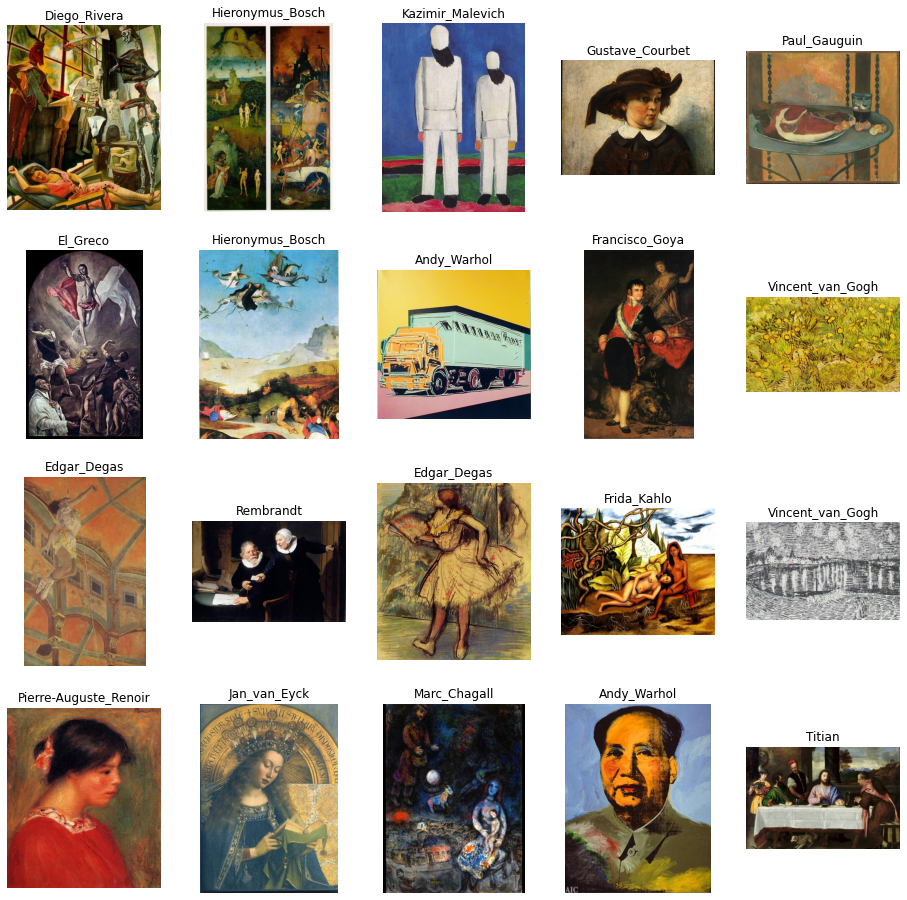

In [8]:
img_list = os.listdir(train_dir)
total_len = len(img_list)
randomlist = random.sample(range(0,total_len), 20)
print("training 畫作總共畫作有 : ",total_len)

show_imgs = [img_list[rand] for rand in randomlist]

plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
    imgpath = train_dir+imgName
    img = cv.imread(imgpath)
    print(imgpath)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.subplot(4,5,index+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("_".join(imgName.split("_")[:-1]))

## 3. 資料前處理




# OverSampling


In [9]:
# overSampling
def overSampling():
  for i in range(0, 50):
    print(i)
    rand_bond = artists.paintings[i]-1
    while artists.paintings[i] < 150 and artists.paintings[i] < rand_bond*4 :
      rand_num = random.randint(0, rand_bond)
      rand_path = train_dir + artists.name[i] + '_' + str(rand_num) + '.jpg'
      des_path = train_dir + artists.name[i] + '_' + str(artists.paintings[i]+1) + '.jpg'
      print(des_path)
      if os.path.exists(rand_path):
        shutil.copyfile(rand_path, des_path)
        image = Image.open(des_path)
        rand_trans = random.randint(0,2)
        if rand_trans % 3 == 0:
          image = image.transpose(Image.FLIP_LEFT_RIGHT)
        elif rand_trans % 3 == 1:
          image = image.transpose(Image.FLIP_TOP_BOTTOM)
        elif rand_trans % 3 == 2:
          image = image.transpose(Image.ROTATE_90)

        image.save(des_path)
        artists.paintings[i]+=1
      
# overSampling()

In [10]:
# 請建立將英文映射成數字的dict。EX: Van_Gogh --> 0

# def make_Authordict(dataframe):
#   dict = dataframe.to_dict()
#   return dict

# class_name = make_Authordict(artists['name'])
author_Dict = dict()

def make_Authordict():
  index = 0
  for i in artists["name"]:
    author_Dict[i] = index
    index = index+1
  return author_Dict

class_name = make_Authordict()

# 請建立將數字映射成英文的dict。 EX: 0 --> Van_Gogh
rev_class_name = {v: k for k, v in author_Dict.items()}

In [11]:
def get_label(picName):
  # 請取出label並轉成數字
  # EX: Claude_Monet_1.jpg -> Claude_Monet -> 1
  # 先切最後一個底線前的字串
  picName = picName.rpartition('_')[0]
  # 對應到數字
  return author_Dict[picName] 

def get_path(dir,picName):
  # 請將路徑合併
  # EX: ./train_resized/ + Claude_Monet_1.jpg => ./train_resized/Claude_Monet_1.jpg
  path = dir + picName
  return path
def make_paths_label(dir):
  img_list = os.listdir(dir)
  paths = []
  labels = []
  
  # 將preprocess完成的path、label用for迴圈放入paths和labels
  for path in img_list:
    labels.append(get_label(path))
    paths.append(get_path(dir,path))
    onehot_labels = np.eye(50)[labels]

  # 將labels轉成onehot
  # todo
  # onehot_labels = keras.utils.to_categorical(labels, num_classes)
  return paths,onehot_labels

In [12]:
# 來查看一下
paths,onehot_labels = make_paths_label(train_dir)

print("paths : ")
for p in paths[:5]:
  print(p)
print("-"*20)
print("labels : ")
for label in onehot_labels[:5]:
  print(label)

paths : 
./train_resized/Paul_Gauguin_139.jpg
./train_resized/Francisco_Goya_135.jpg
./train_resized/Pierre-Auguste_Renoir_202.jpg
./train_resized/Paul_Klee_147.jpg
./train_resized/Marc_Chagall_9.jpg
--------------------
labels : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

* 目標輸出

![](https://i.imgur.com/CSzFlZ2.png)

In [13]:
# 轉成tensorflow dataset格式，變成路徑tensor
# 這個只是from_tensor_slices範例
paths_ds = tf.data.Dataset.from_tensor_slices(paths)
train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

print("turn to tensor")
for tensor in paths_ds.take(5):
  print(tensor)

turn to tensor
tf.Tensor(b'./train_resized/Paul_Gauguin_139.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Francisco_Goya_135.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Pierre-Auguste_Renoir_202.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Paul_Klee_147.jpg', shape=(), dtype=string)
tf.Tensor(b'./train_resized/Marc_Chagall_9.jpg', shape=(), dtype=string)


In [14]:
# 決定你輸入模型的圖片長寬
# shuffle buffle size
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SIZE = None
shuffle_buffer = 1000

def get_image(path):
  # read image from path
  file = tf.io.read_file(path)
  img = tf.io.decode_jpeg(file,channels=3)
  img = tf.cast(img,tf.float32)/255

  # 請固定每張圖片大小為IMG_HEIGHT、IMG_WIDTH
  # 並將圖片每個pixel映射到[0,1]之間
  img = tf.image.resize(img,[IMG_WIDTH,IMG_HEIGHT])

  return img

# 將所有資料轉成Tensor -> Tensor 轉成圖片
# 圖片Tensor 與 label Tensor Zip起來成一個pair
# shuffle打散
def make_dataset(dir):
  paths,onehot_labels = make_paths_label(dir)
  paths_ds = tf.data.Dataset.from_tensor_slices(paths)
  train_label = tf.data.Dataset.from_tensor_slices(onehot_labels)

  # 將路徑tensor映射成圖片tensor 
  train_image = paths_ds.map(get_image)
  # 合併圖片與label資料集
  full_ds = tf.data.Dataset.zip((train_image,train_label))
  # 打散
  full_ds = full_ds.shuffle(shuffle_buffer,reshuffle_each_iteration=True)
  return full_ds

full_ds = make_dataset(train_dir)

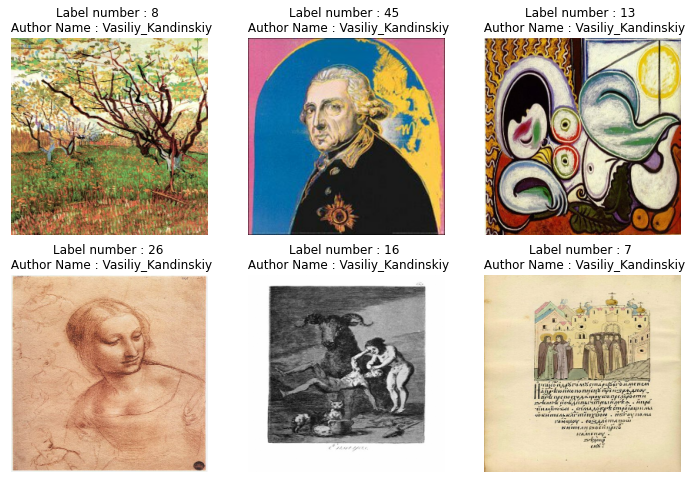

In [15]:
# 取出Tensor圖片來看看
plt.figure(figsize=(12, 8))
for index,(img,label) in enumerate(full_ds.take(6)):
    l = np.argmax(label.numpy())
    plt.subplot(2,3,index+1)
    plt.imshow(img)
    plt.title("Label number : {} \n Author Name : {}".format(
        l,
        rev_class_name[1]))
    plt.axis("off")

* 目標輸出

![](https://i.imgur.com/gvwxegB.png)

In [16]:
# 切割成training data與validation data
train_len = int(0.8*total_len)
val_len = total_len - train_len

train_ds = full_ds.take(train_len)
val_ds = full_ds.skip(train_len)

print("train size : ",train_len," val size : ",val_len)

# 添加batch
# todo
batch_size = 32

train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train size :  6016  val size :  1504


In [17]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x,y = trainiter.next()
print("training image batch shape : ",x.shape)
print("training label batch shape : ",y.shape)

training image batch shape :  (32, 256, 256, 3)
training label batch shape :  (32, 50)


## 4. 建立模型

發揮你的創意，建立模型。

請不要用已有的知名模型做fine-tuning，**請自己手動建**。

In [18]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)

# 資料增強
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)
# 自訂你的model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
     
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
     
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
     
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
     
        layers.Conv2D(1024, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
     
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(512,activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                      

## 5. 制定訓練計畫

把前處理完的資料輸入進去

1~100 epoch

In [23]:
# todo
epochs = 50

# model.compile 決定learning strategy、Loss caculator
import tensorflow_addons as tfa
from keras import optimizers

radam = tfa.optimizers.RectifiedAdam(0.0002)
ranger = tfa.optimizers.Lookahead(radam,sync_period=6,slow_step_size=0.5)

model.compile(loss = "categorical_crossentropy",optimizer = ranger,metrics = ["accuracy"])

history = model.fit(train_ds,batch_size=batch_size,epochs=epochs,validation_data=val_ds,callbacks=[
    keras.callbacks.ModelCheckpoint("art_model_cool_best/model_{epoch:02d}",save_best_only=True)                                                                                                       
]) 

Epoch 1/50
188/188 [==============================] - 72s 326ms/step - loss: 0.1418 - accuracy: 0.9558 - val_loss: 0.8092 - val_accuracy: 0.8411
Epoch 2/50
188/188 [==============================] - 63s 321ms/step - loss: 0.0667 - accuracy: 0.9786 - val_loss: 0.7150 - val_accuracy: 0.8597
Epoch 3/50
188/188 [==============================] - 64s 325ms/step - loss: 0.0430 - accuracy: 0.9865 - val_loss: 0.6974 - val_accuracy: 0.8664
Epoch 4/50
188/188 [==============================] - 63s 321ms/step - loss: 0.0336 - accuracy: 0.9909 - val_loss: 0.6562 - val_accuracy: 0.8717
Epoch 5/50
188/188 [==============================] - 59s 300ms/step - loss: 0.0296 - accuracy: 0.9919 - val_loss: 0.6720 - val_accuracy: 0.8690
Epoch 6/50
188/188 [==============================] - 62s 319ms/step - loss: 0.0291 - accuracy: 0.9932 - val_loss: 0.6382 - val_accuracy: 0.8777
Epoch 7/50
188/188 [==============================] - 59s 301ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 0.6670 - val_ac

In [27]:
model.save('model_acc66')

INFO:tensorflow:Assets written to: model_acc66/assets


# 再訓練

In [30]:
epochs = 100 

radam = tfa.optimizers.RectifiedAdam(0.00005) # 1/2
ranger = tfa.optimizers.Lookahead(radam,sync_period=6,slow_step_size=0.5)

model.compile(loss = "categorical_crossentropy",optimizer = ranger,metrics = ["accuracy"])

history = model.fit(train_ds,batch_size=batch_size,epochs=epochs,initial_epoch=50,validation_data=val_ds,callbacks=[
    keras.callbacks.ModelCheckpoint("art_model_cool_best/model_{epoch:02d}",save_best_only=True)                                                                                                       
]) 

Epoch 51/100
188/188 [==============================] - 67s 311ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.6145 - val_accuracy: 0.8910
Epoch 52/100
188/188 [==============================] - 57s 286ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.6213 - val_accuracy: 0.8863
Epoch 53/100
188/188 [==============================] - 56s 285ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.6166 - val_accuracy: 0.8876
Epoch 54/100
188/188 [==============================] - 56s 287ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6185 - val_accuracy: 0.8863
Epoch 55/100
188/188 [==============================] - 56s 285ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6196 - val_accuracy: 0.8856
Epoch 56/100
188/188 [==============================] - 59s 301ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.6139 - val_accuracy: 0.8910
Epoch 57/100
188/188 [==============================] - 56s 284ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0

## 6. 評估模型

## 0~50

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


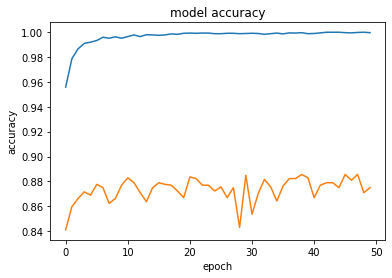

In [24]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

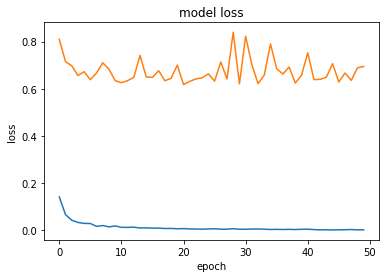

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [26]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

27/27 [==============================] - 3s 32ms/step - loss: 2.0608 - accuracy: 0.6635
Test loss: 2.060823917388916
Test accuracy: 0.6634730696678162


## 50~100 收斂

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


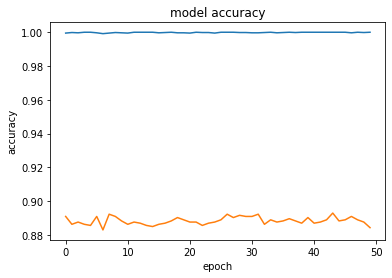

In [31]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

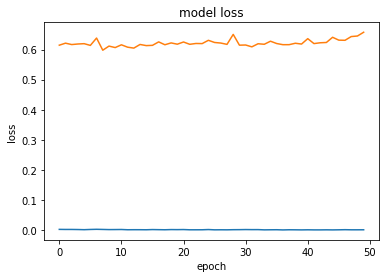

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [33]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

27/27 [==============================] - 3s 32ms/step - loss: 1.9947 - accuracy: 0.6671
Test loss: 1.9947311878204346
Test accuracy: 0.6670658588409424


# 最佳 Model 測試

In [34]:
model_best=tf.keras.models.load_model('art_model_cool_best/model_58')

In [35]:
# 讀入測試資料並評估模型
test_ds = make_dataset(test_dir)
test_ds = test_ds.batch(batch_size)
score = model_best.evaluate(test_ds)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

27/27 [==============================] - 3s 31ms/step - loss: 1.8709 - accuracy: 0.6778
Test loss: 1.870876669883728
Test accuracy: 0.6778442859649658


## 7. 做預測 (10分)
* 把前面讀取的圖片拿來丟入模型做預測
* 自己把一張現實中的圖片丟入Model做預測

In [42]:
def preditAuthor(img):
  # 寫個單圖片模型預測function
  # input : opencv img (height,width,3)
  # output : 某個作家名字 E.g. Claude_Monet
  #
  # 參考步驟:
  # 1. expand img dimension (height,width,3) -> (1,height,width,3)
  # 2. 丟入模型 model.predict
  # 3. 取出softmax後(50,) 取最大值的index作為辨識結果
  # 4. 將辨識結果轉為畫作家名字

  img = np.expand_dims(img, axis=0)
  authorNo = np.argmax(model.predict([img]), axis=-1)[0]
  authorName = rev_class_name[authorNo]

  return authorName

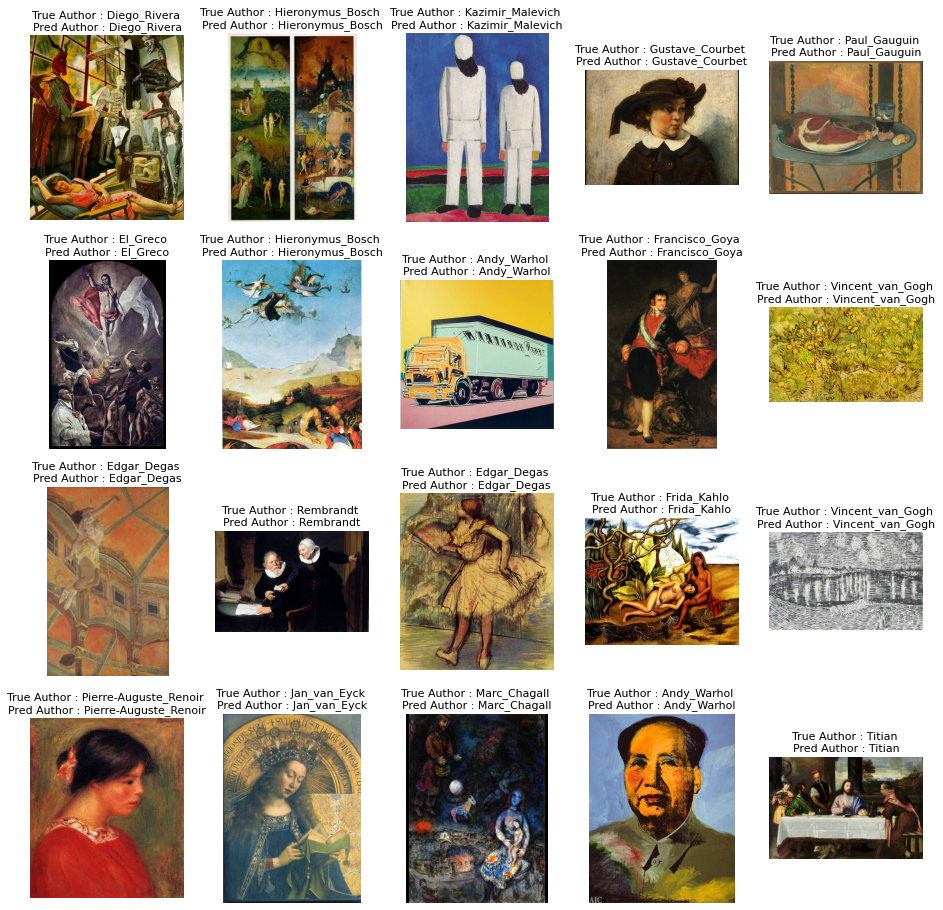

In [43]:
plt.figure(figsize=(16, 16))
for index,imgName in enumerate(show_imgs):
  imgpath = train_dir+imgName
  img = cv.imread(imgpath)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.subplot(4,5,index+1)
  plt.axis("off")
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img / 255.0
  plt.title("True Author : {} \nPred Author : {}".format("_".join(imgName.split("_")[:-1]),preditAuthor(img)),size=11)

* 自己上傳圖片來試試看模型的效果

In [44]:
from google.colab import files

def upload_img():
  uploaded = files.upload()
  img_name = list(uploaded.keys())[0]
  img = cv.imread(img_name)
  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  plt.imshow(img)
  img = cv.resize(img,(IMG_WIDTH,IMG_HEIGHT))
  img = img/255.0
  return img

def eval():
  img = upload_img()
  plt.title("predict author : {}".format(preditAuthor(img)))
  plt.axis("off")
  plt.show()

Saving toast.png to toast (1).png


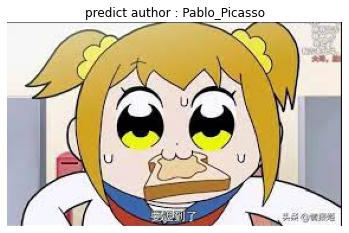

In [45]:
# 自己上傳一張圖片來試試看
# Demo圖片來自:
# Interview with Cyberpunk 2077 "ponpon shit" producer Yuki Kawamura (https://block.fm/news/cyberpunk2077_uscracks_ENG)
eval()